In [2]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
# Boosting model
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


Import and cleaning of our dataset

In [3]:
df = pd.read_csv(r"Clean_dataset.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df = df.drop('Id_Cliente',axis=1) # No need cause it was confusing the model
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Imp_Liquidit�_Attuale_6m,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1634.57,2978.40,2980.92,1550.44,2853.2,2853.22,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0


In [26]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  
XX = pd.get_dummies(X) # It will be useful later to ensure that the column size of all the df is the same (Provincia and Residenza were giving us problem due to their unique values)


In [27]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df
# After creating dummies, the model was not able to elaborate certain columns due to the presence of certain special characters

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility
# To ensure that the size is the same even after the split
XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) 
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]
# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1)
# I didn't know if the code would confuse the df of the last tuning with the final one, i changed names to ensure this don't happen
X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

Import and cleaning of our synthetic dataset previously generated

In [7]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)

We apply the same feature engineering process for the original dataset

In [8]:
synthetic_df=synthetic_df
synthetic_df['Professione'] = synthetic_df['Professione'].apply(lambda x: 'Ufficiale/Sottoufficiale' if x == 'Ufficiale/Sottufficiale' else 
                                                                  'Libero professionista/Titolare impresa' if x == 'Libero professionista/Titolare di impresa' else 
                                                                  x)
synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('FO', 'FC')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('FO', 'FC')

synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('PS', 'PU')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('PS', 'PU')

synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('8N', np.nan)
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('BE', np.nan)
mapping = {
    'CAUTO': 1,
    'PRUDENTE': 2,
    'BILANCIATO': 3,
    'DINAMICO':4,
    'ND':0
}
synthetic_df['Profilo_MIFID'] = synthetic_df['Profilo_MIFID'].replace(mapping)

mapping2 = {
    'Bassissimo (<1200)': 1,
    'Basso (tra 1200 e 1500)': 2,
    'Medio (tra 1500 e 1800)': 3,
    'Alto (tra 1800 e 2500)':4,
    'Altissimo (>2500)':5
}

synthetic_df['Imp_Reddito'] = synthetic_df['Imp_Reddito'].replace(mapping2)
#log transformation done during feature engineering
synthetic_df['log_Imp_Bonifici_vs_Competitors'] = np.log10(synthetic_df['Imp_Bonifici_vs_Competitors'])
synthetic_df['log_Imp_Bonifici_vs_No_Competitors'] = np.log10(synthetic_df['Imp_Bonifici_vs_No_Competitors'])
synthetic_df['log_Imp_Gestito_attuale'] = np.log10(synthetic_df['Imp_Gestito_attuale'])
synthetic_df['log_Num_Punti_Programma_Loyalty'] = np.log10(synthetic_df['Num_Punti_Programma_Loyalty'])
synthetic_df = synthetic_df.drop(['Imp_Bonifici_vs_Competitors', 'Imp_Bonifici_vs_No_Competitors', 'Imp_Gestito_attuale', 'Num_Punti_Programma_Loyalty', 'Imp_Gestito_attuale_6m', 'Imp_Liquidit�_Attuale_6m', 'Imp_Amministrato_attuale_6m'], axis =1)

In [42]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  

In [43]:
# Same process as before to ensure that column lenght is the same since once we train our model with specific columns, we need to ensure that our model has in input a df with same lenght and names
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 279)


LightGBM : Tuning hyperparametri

In [ ]:
def objective(trial): # A trial is a process of evaluating an objective function
    #
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # Rateo between minority and majority class to deal with the unbalance nature of the dataset
# Now we set the parameters for the tuning: the range is wide and the reason will be explained soon
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1
    }
# We use CV to ensure that our model is able to generalize, and it's not just luck with a lucky split
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # the number of split is equal to 10 to ensure that each row of the df has been once in the test set and 9 times in the train
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index] # #y_fold_val is 30190

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # We predict the probability
        top_indices = np.argsort(probas)[-5000:]  # Sort the probability is descending order and select top 5000 (1:6 of the total more or less)
     # Now we count the number of positive contained in our choosen list out of the total as metric  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum()  
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores) # Mean for every split
# Optuna provide us the TPE Sampler: it's a Bayesian hyperparameter optimization algorithms that is able to learn about the relationship between the hyperparameters and the objective function to choose the parameters for each tria
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50) 

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()


[I 2024-04-23 16:59:33,433] A new study created in memory with name: no-name-2f04d833-6fae-4c5b-acfc-7302d4a43292
[I 2024-04-23 17:00:18,262] Trial 0 finished with value: 0.5867924528301887 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 0.5867924528301887.
[I 2024-04-23 17:01:39,726] Trial 1 finished with value: 0.679874213836478 and parameters: {'n_estimators': 294, 'learning_rate': 0.0823143373099555, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 17, 'subsample': 0.8608484485919076, 'subsample_freq': 4, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'max_bin': 214}. Best is trial 1 with value: 0.679874213836478.
[I 2024-04-23 1

KeyboardInterrupt: 

In [76]:
# We stopped the tuning earlier since we found a good set of parameters and tuning wasn't giving us better results but was converging to the same parameters
'''
[I 2024-04-23 17:36:46,835] Trial 26 finished with value: 0.8232704402515724 and parameters: {'n_estimators': 297, 'learning_rate': 0.010065762501114987, 'max_depth': 13, 'num_leaves': 25, 'min_child_samples': 28, 'subsample': 0.9186047768818155, 'subsample_freq': 5, 'colsample_bytree': 0.8969786318428297, 'reg_alpha': 0.9097824682690728, 'reg_lambda': 0.6075396766185748, 'max_bin': 289}. Best is trial 26 with value: 0.8232704402515724.
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 297,
    "learning_rate": 0.010065762501114987,
    "max_depth": 13,
    "num_leaves": 25,
    "min_child_samples": 28,
    "subsample": 0.9186047768818155,
    "subsample_freq": 5,
    "colsample_bytree": 0.8969786318428297,
    "reg_alpha": 0.9097824682690728,
    "reg_lambda": 0.6075396766185748,
    "max_bin": 289,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

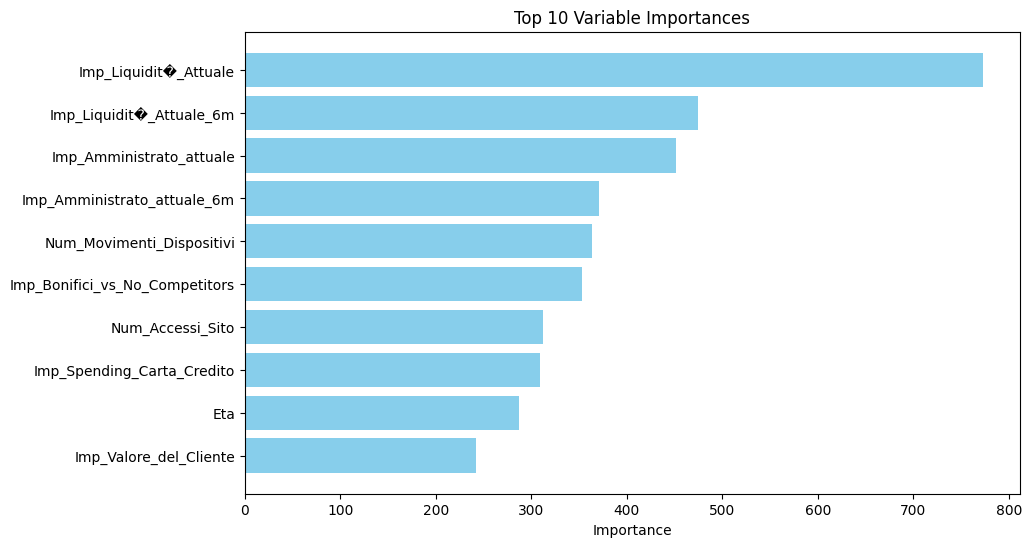

In [ ]:
# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  
plt.show()

We want to see how our final model perform on test set, selecting the top 10k clients with higher probability to be in the minority class

In [ ]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': lgbm_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
25853        1      0.939213
20382        1      0.935142
17678        1      0.931822
41726        1      0.929507
118461       0      0.928897
...        ...           ...
105472       0      0.516671
231329       0      0.516663
358251       0      0.516658
53186        0      0.516629
226304       0      0.516595

[10000 rows x 2 columns]


In [ ]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 307
Numero di 'SI: nel nostro test set 393


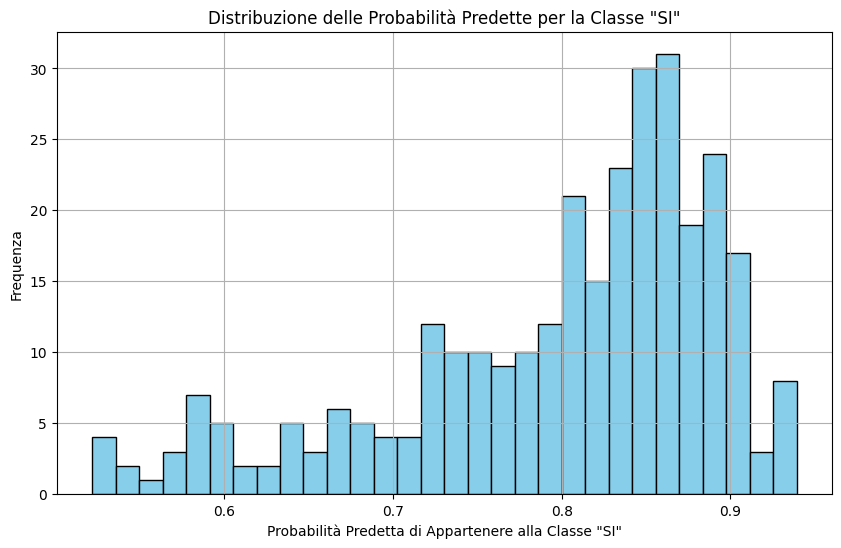

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

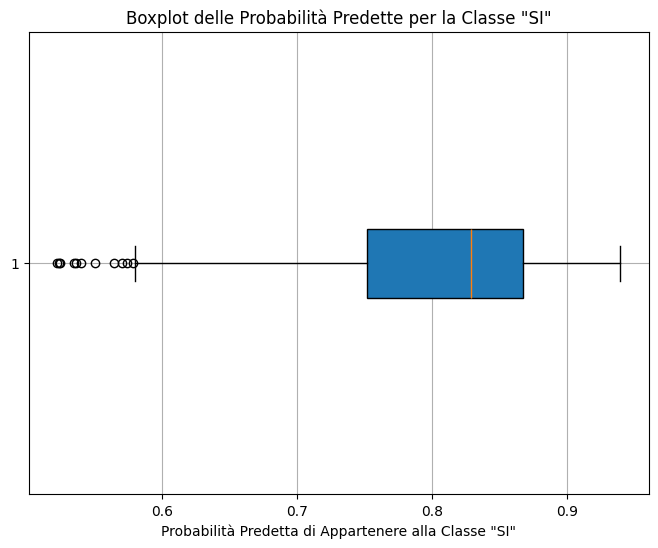

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

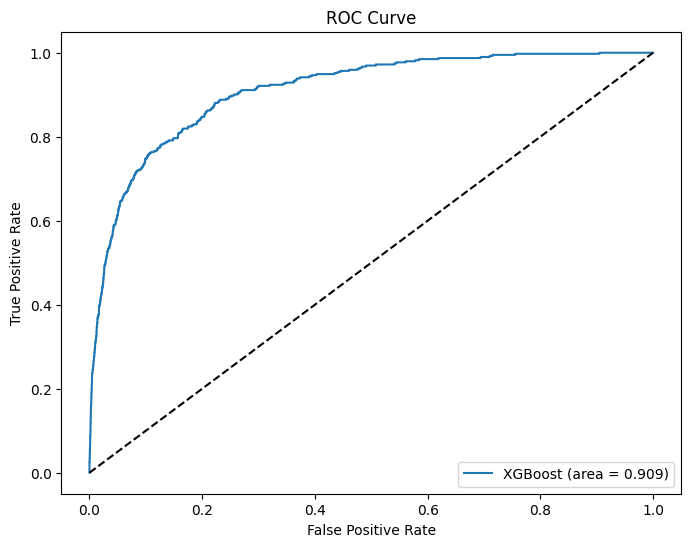

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_final, lgbm_predictions)
auc = roc_auc_score(y_test_final, lgbm_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

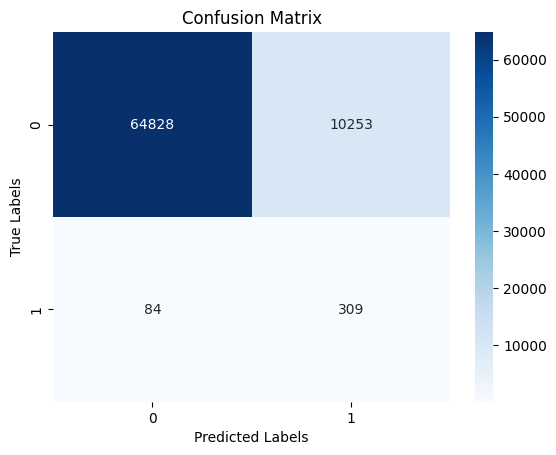

In [ ]:
y_pred = best_lgb_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


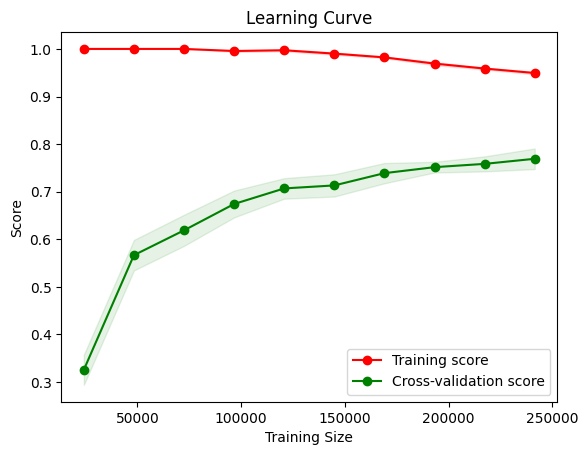

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_lgb_classifier, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

the gap between them does not appear to be widening as the training size increases. This suggests that the model is not severely overfitting, as the cross-validation score is improving . The model should be able to generalize on new unseen data, let's see in practice:

Let's test on the synthetic dataset

In [ ]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
12540       0      0.908441
25811       0      0.907696
40849       0      0.906703
62814       0      0.906341
27956       0      0.905096
...       ...           ...
62870       0      0.469482
18839       0      0.469453
6865        0      0.469448
8420        0      0.469415
37934       0      0.469364

[10000 rows x 2 columns]


In [ ]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 197
Numero di 'SI: nel nostro test set 489


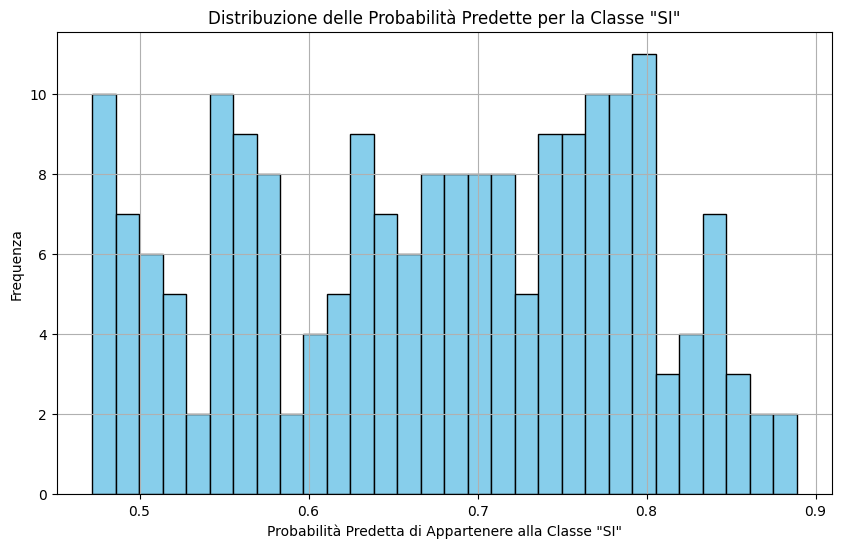

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

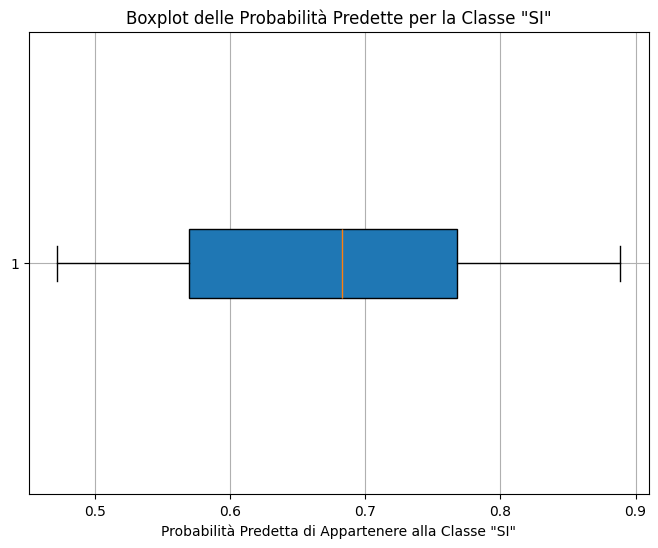

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

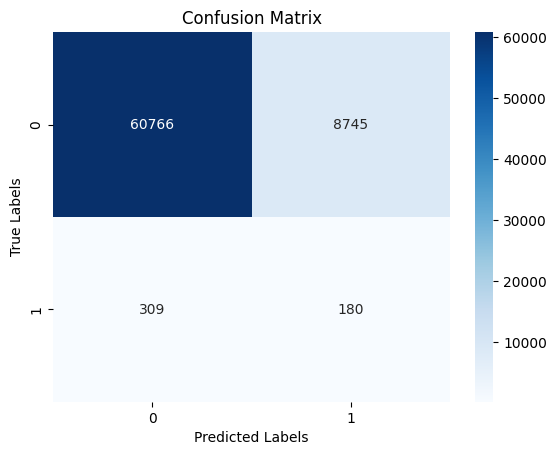

In [ ]:
y_pred = best_lgb_classifier.predict(X_train_res_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

XGBoost: Tuning hyperparametri

In [ ]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'scale_pos_weight': scale_pos_weight, 
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1] 
        top_indices = np.argsort(probas)[-5000:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-04-23 18:25:36,563] A new study created in memory with name: no-name-7f61beb0-9397-4fde-8209-afe885071ea8
[I 2024-04-23 18:33:49,490] Trial 0 finished with value: 0.6874213836477987 and parameters: {'n_estimators': 437, 'learning_rate': 0.4123206532618726, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 6.051038616257767}. Best is trial 0 with value: 0.6874213836477987.
[I 2024-04-23 18:47:04,793] Trial 1 finished with value: 0.7962264150943396 and parameters: {'n_estimators': 737, 'learning_rate': 0.01083858126934475, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 5.295088673159155}. Best is trial 1 with value: 0.7962264150943396.
[I 2024-04-23 18:54:46,730] Trial 2 finished with value: 0.803144654088

Best Hyperparameters: {'n_estimators': 661, 'learning_rate': 0.036491004518573594, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 4.7749277591032975}
Best Score for Top 50,000: 0.829559748427673


In [77]:
import xgboost
'''
Best Hyperparameters: {'n_estimators': 661, 'learning_rate': 0.036491004518573594, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 4.7749277591032975}
Best Score for Top 50,000: 0.829559748427673
'''
# There was a problem with the parameters verbosity, I had to set manually a value in range in main xgboost configuration
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
xgboost.config_context(verbosity=0)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_params = {
    'n_estimators': 661,
    'learning_rate': 0.036491004518573594,
    'max_depth': 3,
    'min_child_weight': 4,
    'subsample': 0.6625916610133735,
    'colsample_bytree': 0.864803089169032,
    'gamma': 3.1877873567760657,
    'reg_alpha': 4.436063712881633,
    'reg_lambda': 4.7749277591032975,
    'scale_pos_weight': scale_pos_weight,
}

best_xgb_classifier = xgb.XGBClassifier(verbosity=0, **xgb_params)

best_xgb_classifier.fit(X_train_final, y_train_final)
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]

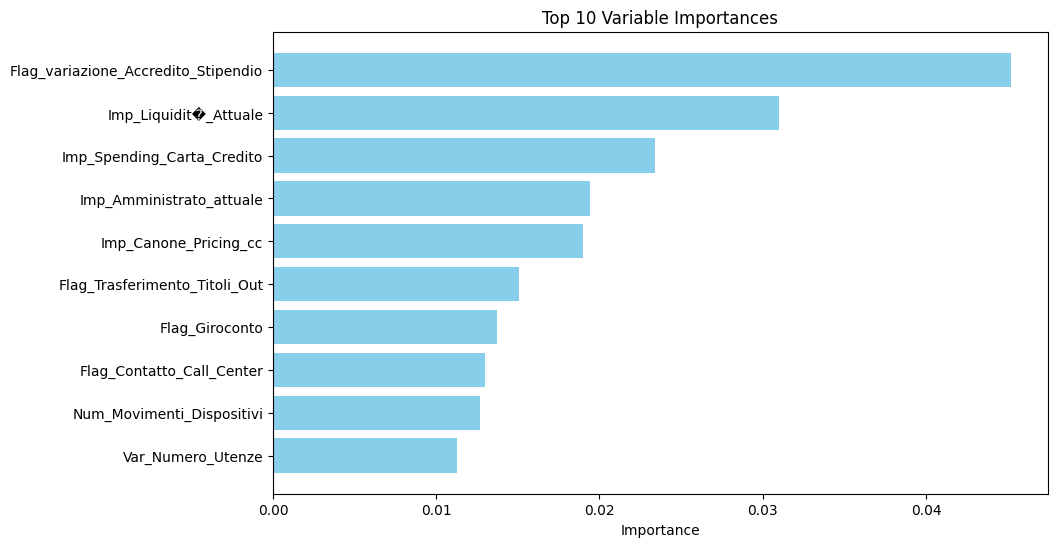

In [ ]:
# Get feature importances
importance = best_xgb_classifier.feature_importances_
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis() 
plt.show()


In [ ]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': xgb_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17678        1      0.999272
117164       0      0.999015
288850       0      0.998376
58243        1      0.998306
168555       0      0.997509
...        ...           ...
236227       0      0.536160
218655       0      0.536155
33818        0      0.536124
100392       0      0.536087
232566       0      0.536039

[10000 rows x 2 columns]


In [ ]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 313
Numero di 'SI: nel nostro test set 108


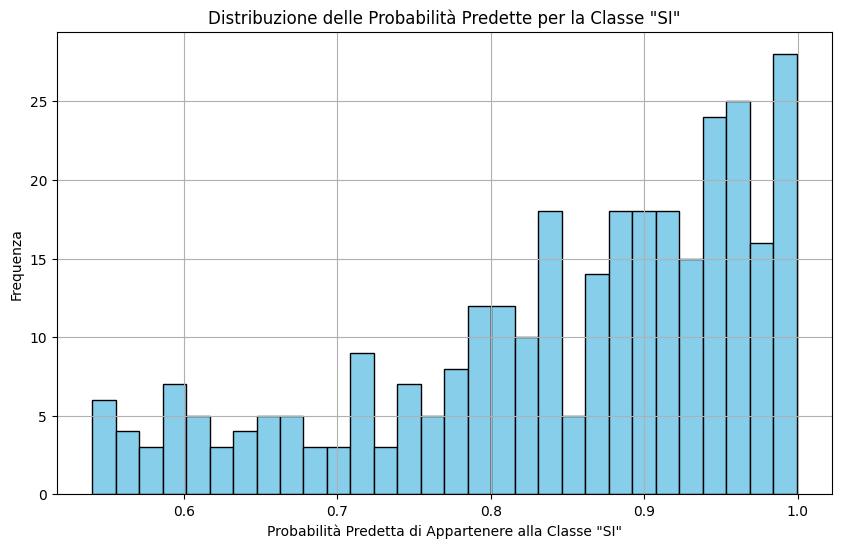

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

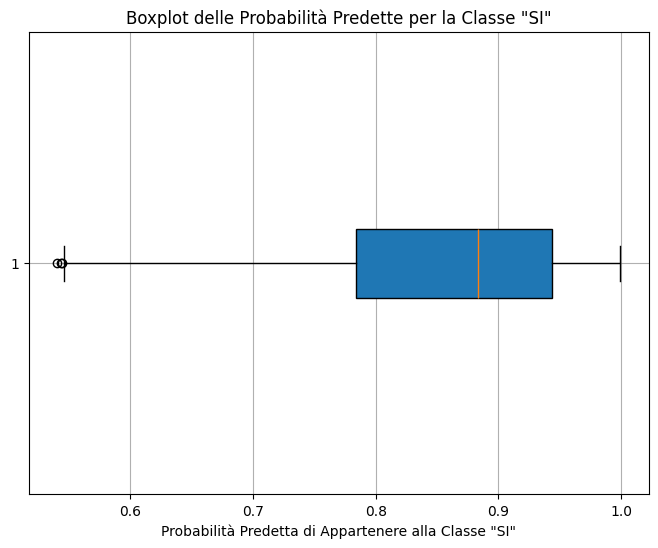

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

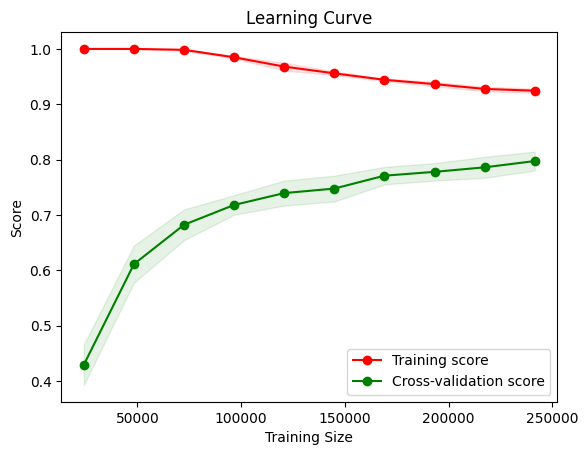

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_xgb_classifier, X_train_final, y_train_final, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

Testiamo ora sul dataset sintetico

In [44]:
X_train_res_synthetic.rename(columns={
    'Professione_Libero professionista/Titolare impresa': 'Professione_Libero_professionista/Titolare_impresa'
}, inplace=True)
#missmatch between column_names

In [45]:
xgb_predictions = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': xgb_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
27956       0      0.991583
6162        0      0.988776
64438       0      0.987223
32924       0      0.986923
33720       0      0.986624
...       ...           ...
1441        0      0.501621
10897       0      0.501605
23054       0      0.501580
22446       0      0.501580
23019       0      0.501565

[10000 rows x 2 columns]


In [46]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 210
Numero di 'SI: nel nostro test set 489


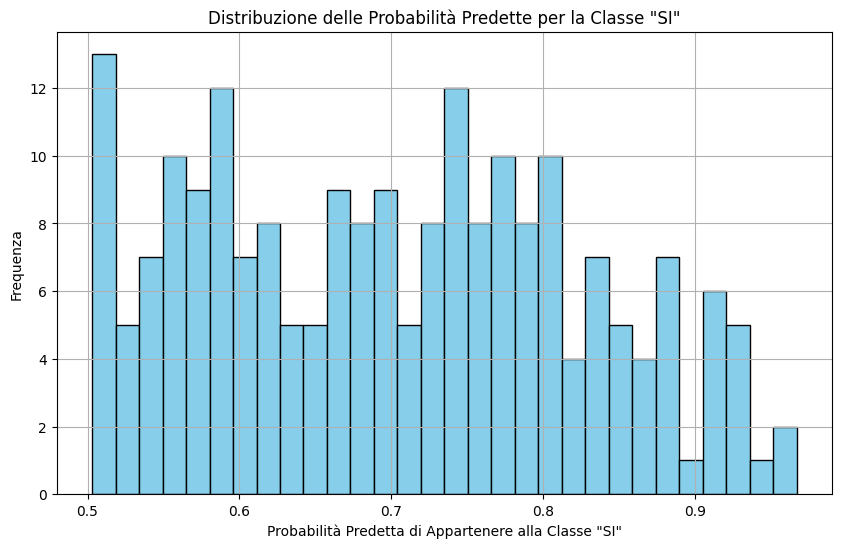

In [47]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

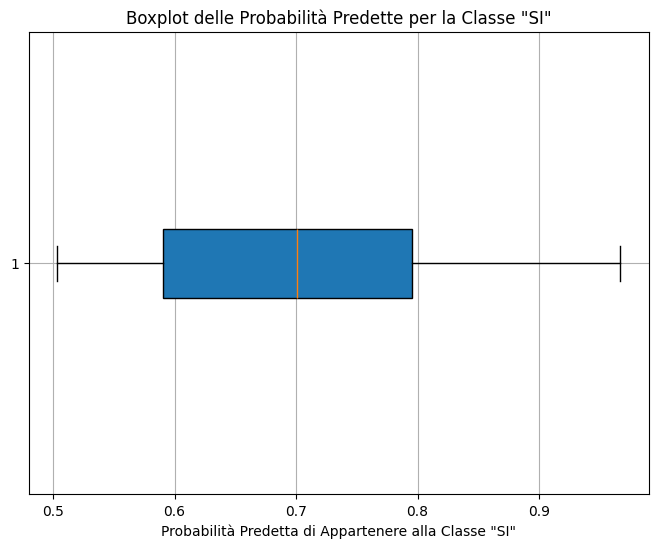

In [48]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

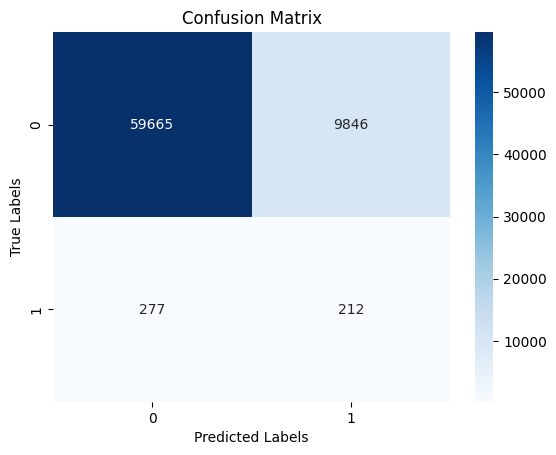

In [51]:
y_pred = best_xgb_classifier.predict(X_train_res_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Catboost: Tuning hyperparametri

In [59]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'scale_pos_weight': scale_pos_weight, 
        'verbose': False
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = cb.CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1] 
        top_indices = np.argsort(probas)[-5000:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-04-24 19:43:04,305] A new study created in memory with name: no-name-b957e9e0-ceac-4513-bf7b-40b910cd4af8
[I 2024-04-24 19:47:33,386] Trial 0 finished with value: 0.8188679245283019 and parameters: {'n_estimators': 250, 'learning_rate': 0.17254716573280354, 'max_depth': 13, 'l2_leaf_reg': 5.986986183486169, 'border_count': 66, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient'}. Best is trial 0 with value: 0.8188679245283019.
[I 2024-04-24 19:49:59,219] Trial 1 finished with value: 0.7924528301886793 and parameters: {'n_estimators': 433, 'learning_rate': 0.018891200276189388, 'max_depth': 7, 'l2_leaf_reg': 1.8348616940244846, 'border_count': 100, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient'}. Best is trial 0 with value: 0.8188679245283019.
[I 2024-04-24 19:55:18,566] Trial 2 finished with value: 0.7823899371069182 and parameters

Best Hyperparameters: {'n_estimators': 486, 'learning_rate': 0.08564115269968339, 'max_depth': 5, 'l2_leaf_reg': 5.495063193351241, 'border_count': 113, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 9, 'leaf_estimation_method': 'Gradient'}
Best Score for Top 50,000: 0.8327044025157233


In [78]:
'''
Best Hyperparameters: {'n_estimators': 486, 'learning_rate': 0.08564115269968339, 'max_depth': 5, 'l2_leaf_reg': 5.495063193351241, 'border_count': 113, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 9, 'leaf_estimation_method': 'Gradient'}
Best Score for Top 50,000: 0.8327044025157233
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

catboost_params = {
    'n_estimators': 486,
    'learning_rate': 0.08564115269968339,
    'max_depth': 5,
    'l2_leaf_reg': 5.495063193351241,
    'border_count': 113,
    'grow_policy': 'SymmetricTree',
    'min_data_in_leaf': 8,
    'leaf_estimation_iterations': 9,
    'leaf_estimation_method': 'Gradient',
    'scale_pos_weight': scale_pos_weight,
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train_final, y_train_final)
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]


0:	learn: 0.6633804	total: 55.9ms	remaining: 27.1s
1:	learn: 0.6394381	total: 112ms	remaining: 27.1s
2:	learn: 0.6182192	total: 167ms	remaining: 26.9s
3:	learn: 0.5990031	total: 218ms	remaining: 26.3s
4:	learn: 0.5832813	total: 265ms	remaining: 25.5s
5:	learn: 0.5696593	total: 313ms	remaining: 25s
6:	learn: 0.5572461	total: 358ms	remaining: 24.5s
7:	learn: 0.5457160	total: 407ms	remaining: 24.3s
8:	learn: 0.5371766	total: 455ms	remaining: 24.1s
9:	learn: 0.5294709	total: 508ms	remaining: 24.2s
10:	learn: 0.5212493	total: 555ms	remaining: 24s
11:	learn: 0.5127680	total: 602ms	remaining: 23.8s
12:	learn: 0.5044516	total: 648ms	remaining: 23.6s
13:	learn: 0.4982165	total: 695ms	remaining: 23.4s
14:	learn: 0.4925573	total: 746ms	remaining: 23.4s
15:	learn: 0.4882312	total: 794ms	remaining: 23.3s
16:	learn: 0.4838150	total: 845ms	remaining: 23.3s
17:	learn: 0.4782039	total: 895ms	remaining: 23.3s
18:	learn: 0.4739136	total: 944ms	remaining: 23.2s
19:	learn: 0.4697709	total: 993ms	remaining:

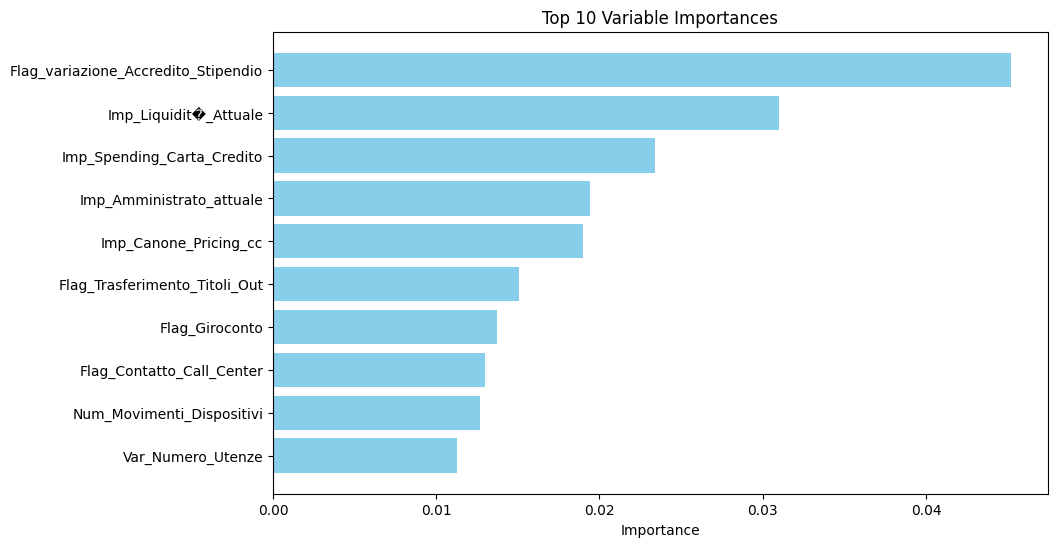

In [61]:
importance = best_xgb_classifier.feature_importances_
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [62]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': catboost_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
117164       0      0.997390
288850       0      0.997365
91629        0      0.997232
17678        1      0.997139
104877       0      0.997013
...        ...           ...
43578        0      0.493932
134770       0      0.493925
85796        0      0.493917
283107       0      0.493910
1601         0      0.493906

[10000 rows x 2 columns]


In [63]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 314
Numero di 'SI: nel nostro test set 393


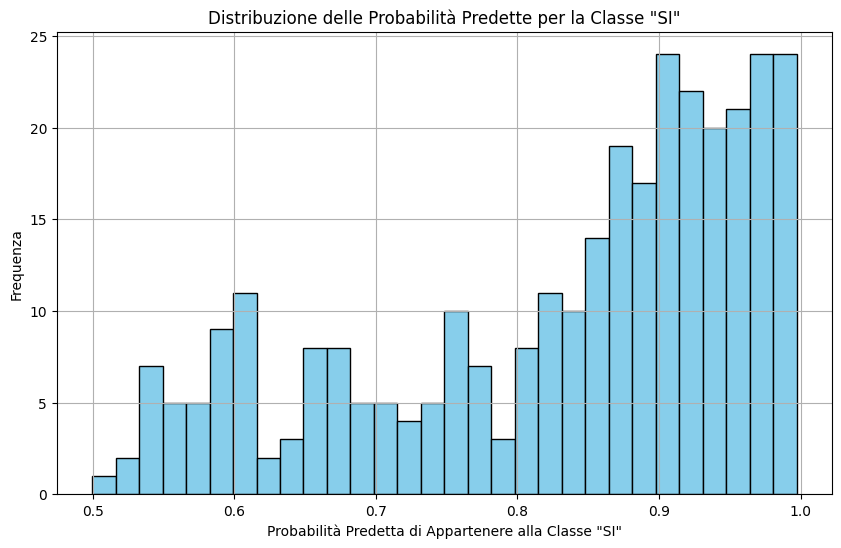

In [64]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

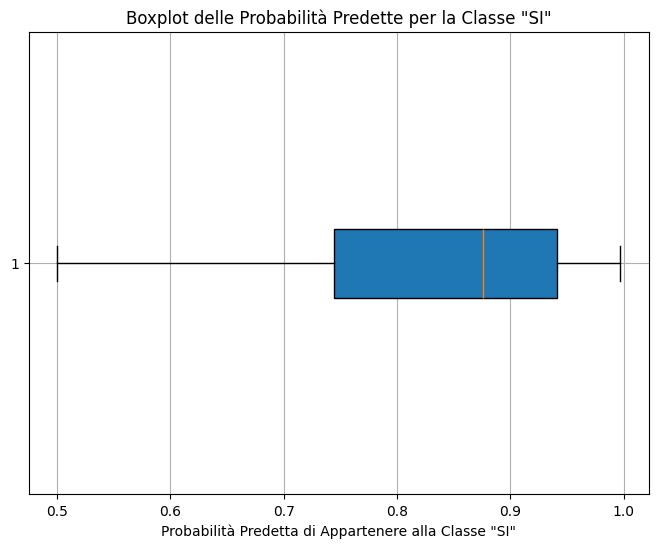

In [65]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

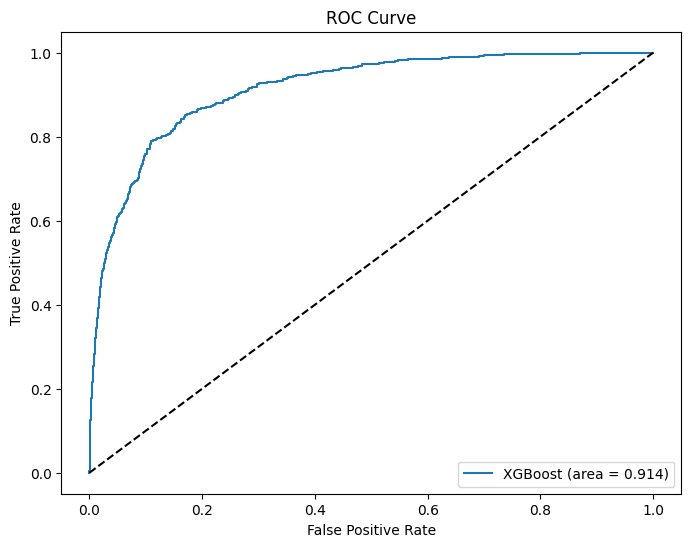

In [66]:
fpr, tpr, thresholds = roc_curve(y_test_final, catboost_predictions)
auc = roc_auc_score(y_test_final, catboost_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

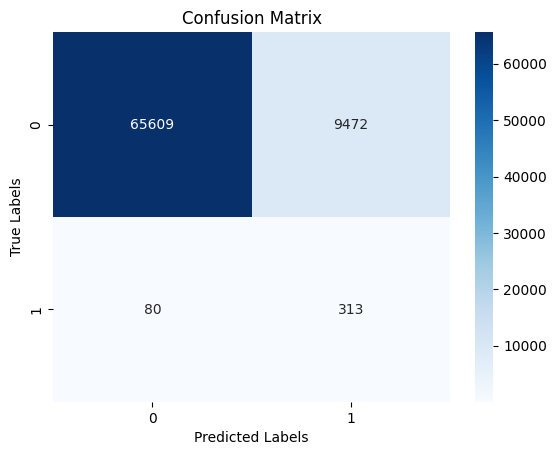

In [67]:
y_pred = best_catboost_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


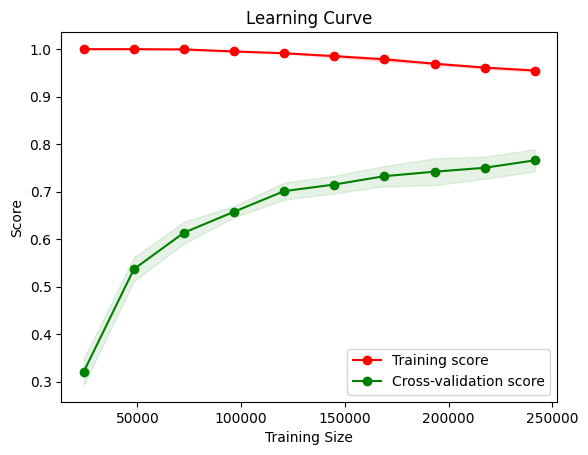

In [69]:
train_sizes, train_scores, test_scores = learning_curve(best_catboost_classifier, X_train_final, y_train_final, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

Testiamo ora sul dataset sintetico

In [70]:
catboost_predictions = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': catboost_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
32924       0      0.979519
33720       0      0.979172
64438       0      0.978947
38912       0      0.976927
27956       0      0.972760
...       ...           ...
326         0      0.434133
22531       0      0.434083
29397       0      0.434066
49700       0      0.434042
3749        0      0.434009

[10000 rows x 2 columns]


In [71]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 207
Numero di 'SI: nel nostro test set 489


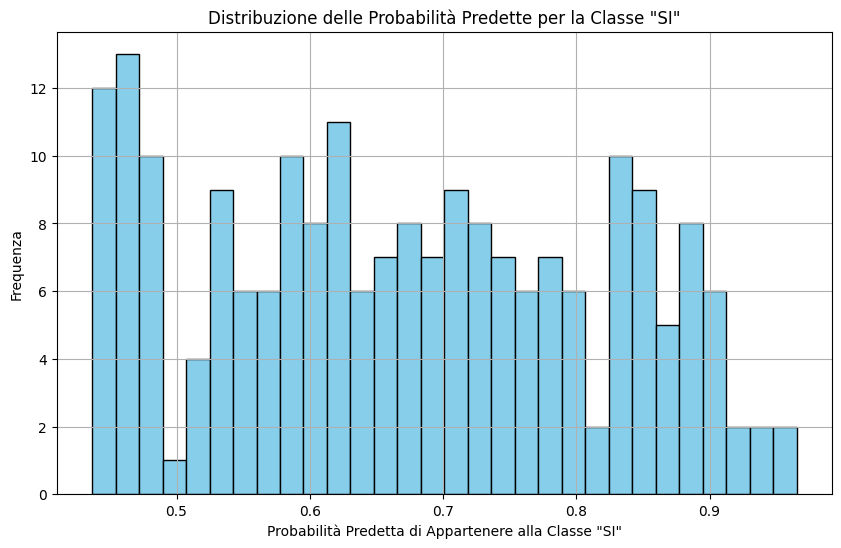

In [72]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

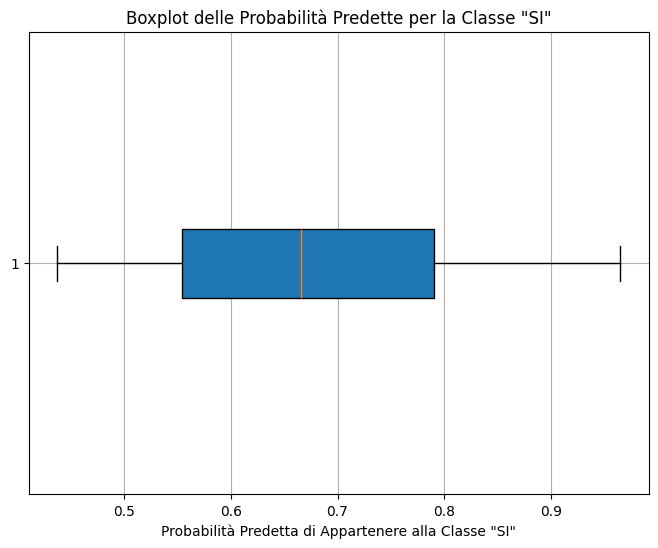

In [73]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

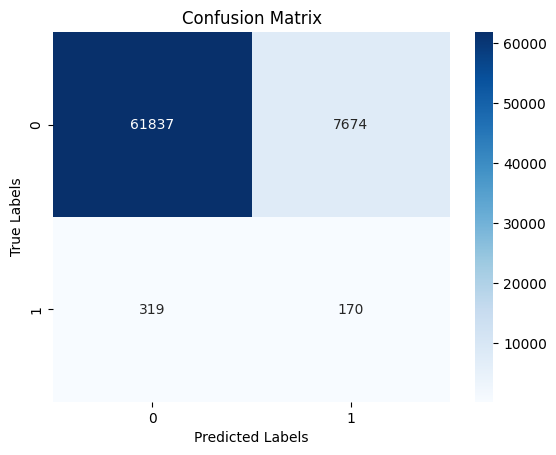

In [75]:
y_pred = best_catboost_classifier.predict(X_train_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Iterazione Metodo Brute Force per trovare i migliori pesi da dare al nostro modello per massimizzare la ROC Curve

In [79]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    weight_catboost = trial.suggest_float('weight_catboost', 0, 1)
    weight_xgb = trial.suggest_float('weight_xgb', 0, 1 - weight_catboost)

    # Calculate weight for LightGBM as the remainder
    weight_lgbm = 1 - weight_catboost - weight_xgb

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        catboost_predictions = best_catboost_classifier.predict_proba(X_fold_val)[:, 1]
        xgb_predictions = best_xgb_classifier.predict_proba(X_fold_val)[:, 1]
        lgbm_predictions = best_lgb_classifier.predict_proba(X_fold_val)[:, 1]
        ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

        top_indices = np.argsort(ensemble_predictions)[-5000:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-04-24 23:42:10,368] A new study created in memory with name: no-name-b18c7748-b9d1-4afd-a2be-6c6accfde669
[I 2024-04-24 23:42:22,669] Trial 0 finished with value: 0.9509433962264152 and parameters: {'weight_catboost': 0.3745401188473625, 'weight_xgb': 0.5946336570972584}. Best is trial 0 with value: 0.9509433962264152.
[I 2024-04-24 23:42:35,079] Trial 1 finished with value: 0.9672955974842766 and parameters: {'weight_catboost': 0.7319939418114051, 'weight_xgb': 0.16044410055080702}. Best is trial 1 with value: 0.9672955974842766.
[I 2024-04-24 23:42:47,074] Trial 2 finished with value: 0.960377358490566 and parameters: {'weight_catboost': 0.15601864044243652, 'weight_xgb': 0.1316564673568783}. Best is trial 1 with value: 0.9672955974842766.
[I 2024-04-24 23:43:02,900] Trial 3 finished with value: 0.9446540880503143 and parameters: {'weight_catboost': 0.05808361216819946, 'weight_xgb': 0.815865506454398}. Best is trial 1 with value: 0.9672955974842766.
[I 2024-04-24 23:43:19,50

Best Hyperparameters: {'weight_catboost': 0.8401280016423606, 'weight_xgb': 0.014810444862548743}
Best Score for Top 50,000: 0.9723270440251571


In [80]:
# Manually set the weight
weight_catboost = 0.84
weight_xgb = 0.02
weight_lgbm = 0.16

In [81]:
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

In [82]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': ensemble_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17678        1      1.006673
25853        1      1.004493
58243        1      1.003854
168555       0      1.003671
257262       0      1.003332
...        ...           ...
142752       0      0.504835
369583       0      0.504636
20769        0      0.504634
330206       0      0.504601
181832       0      0.504592

[10000 rows x 2 columns]


In [83]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 315
Numero di 'SI: nel nostro test set 393


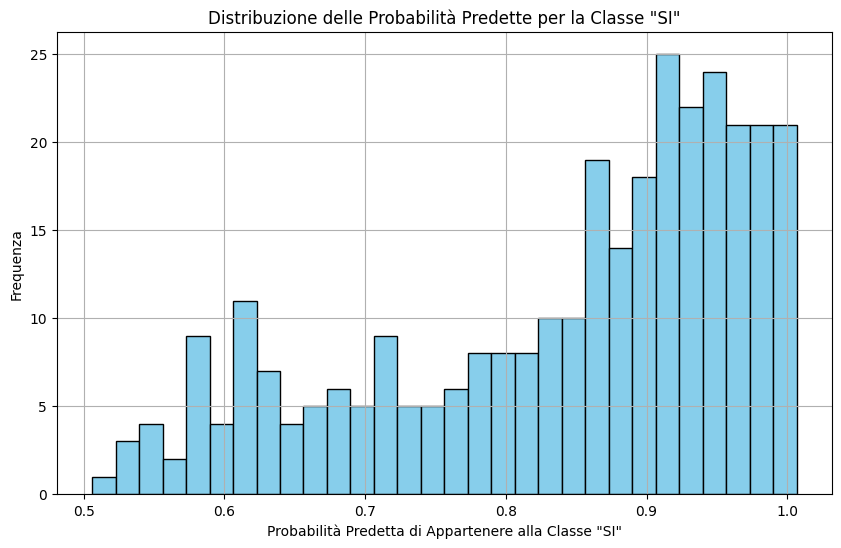

In [84]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

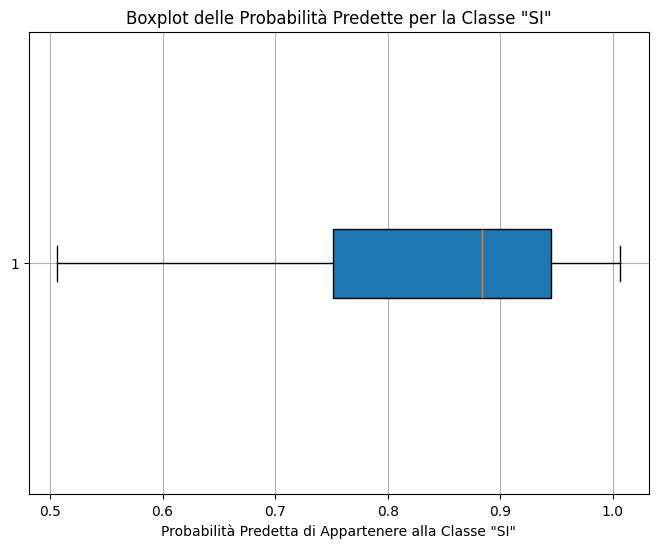

In [85]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

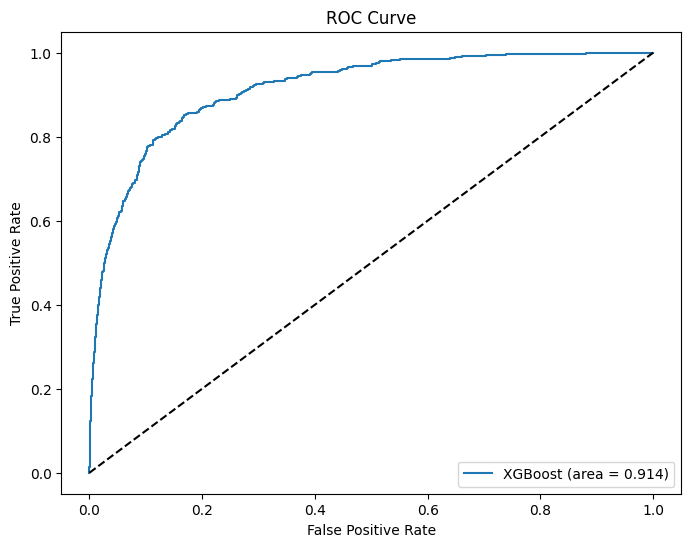

In [86]:
fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

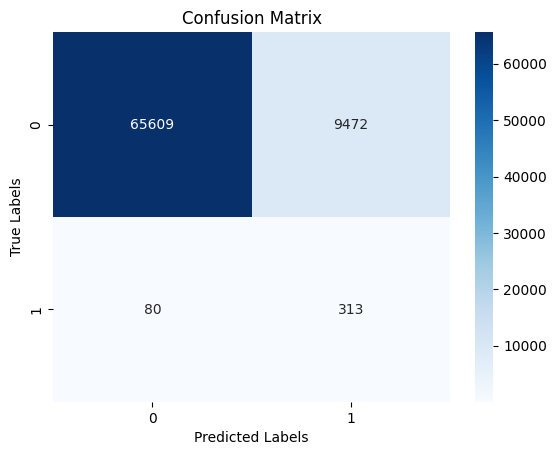

In [88]:
catboost_pred = best_catboost_classifier.predict(X_test_final)
xgb_pred = best_xgb_classifier.predict(X_test_final)
lgbm_pred = best_lgb_classifier.predict(X_test_final)

y_pred = (weight_catboost * catboost_pred) + (weight_xgb * xgb_pred) + (weight_lgbm * lgbm_pred)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test_final, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Testiamo ora sul dataset sintetico

In [89]:
xgb_predictions_synt = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': ensemble_predictions_synth

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
32924       0      0.986354
64438       0      0.985757
33720       0      0.985512
27956       0      0.981765
38912       0      0.978512
...       ...           ...
66241       0      0.446905
69143       0      0.446755
64559       0      0.446742
33958       0      0.446741
16894       0      0.446728

[10000 rows x 2 columns]


In [90]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 205
Numero di 'SI: nel nostro test set 489


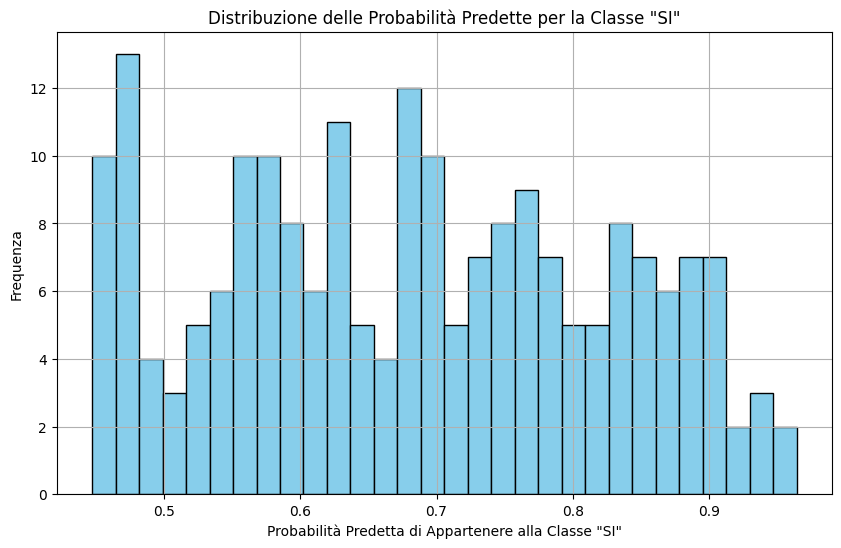

In [91]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

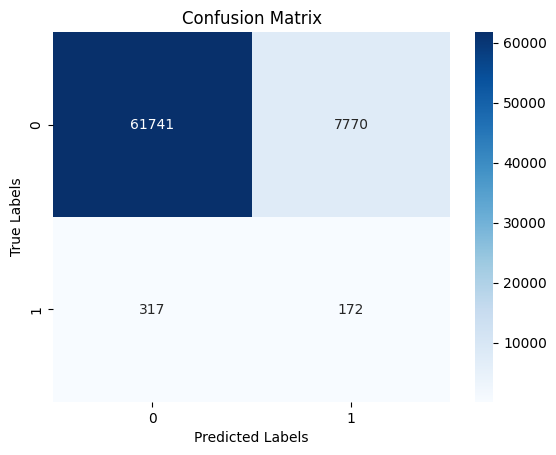

In [92]:
xgb_predictions_synt = best_xgb_classifier.predict(X_train_res_synthetic)
lgbm_predictions_synt = best_lgb_classifier.predict(X_train_res_synthetic)
catboost_predictions_synt = best_catboost_classifier.predict(X_train_res_synthetic)
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)

y_pred_binary = np.where(ensemble_predictions_synth > 0.5, 1, 0)

cm = confusion_matrix(y_synthetic, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()